In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.models import Model


In [47]:
content_path = '/content/1003180000014j6urF3EF_Z_640_10000_R5.jpg_.png'
style_path = '/content/5948c424_image-6-2.jpeg'

In [3]:
model = VGG19(
	include_top=False,
	weights='imagenet'
)
model.trainable = False

model.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [4]:
def load_and_process_image(image_path):
	img = load_img(image_path)
	img = img_to_array(img)
	img = preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img


In [5]:
def deprocess(img):
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def display_image(image):
	if len(image.shape) == 4:
		img = np.squeeze(image, axis=0)

	img = deprocess(img)

	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return


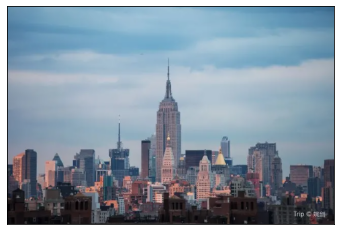

In [48]:
content_img = load_and_process_image(content_path)
display_image(content_img)


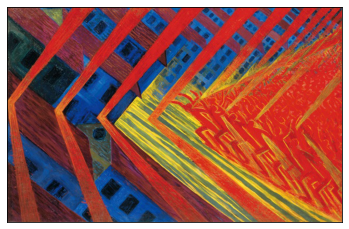

In [49]:
style_img = load_and_process_image(style_path)
display_image(style_img)

In [8]:
content_layer = 'block5_conv2'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


In [9]:
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [10]:
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss


In [11]:
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		current_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += current_cost * weight_of_layer

	return J_style


In [50]:
generated_images = []

# HYPERPARAMS
iterations = 300
a= 100
b = 100000 

def training_loop(content_path, style_path, iterations, a, b):
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = 0
	best_image = None
	for i in range(iterations):
		with tf.GradientTape() as tape:
			J_content = content_loss(content, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [ ]:
# Train the model and get best image
final_img = training_loop(content_path, style_path)


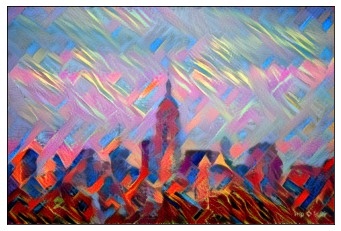

In [59]:
len(generated_images)
# Each iteration will generate a new image which will be saved in the list 'generated_image'
# Check the image you want from the list by using below code
display_image(generated_images[230])



In [70]:
import cv2

def saving_process(img):
  Gen_img = np.reshape(img, (img.shape[1], img.shape[2], img.shape[3]))
  cv2.imwrite("Gen_img.jpg", Gen_img)
  
  return Gen_img 

In [71]:
GG = saving_process(generated_images[230])

In [ ]:
# TUNING HYPERPARAMS WILL BE THE KEY
# TRY DIFF VALUES OF a , b and also iterations to get desired result.